# Summer 2023 Hot/Cold SST Anomaly Match-Up Example

RV Neil Armstrong was in a warm anomaly off the east coast of Labrador on 17-20 July 2023 when the north Atlantic warm anomaly was rapidly growing. It then moved north into a very cold anomaly between Greenland and Canada around 24 July 2023.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import requests
from datetime import datetime, timedelta
import pandas as pd
import json
from shapely.geometry import box
from IPython.display import Image
from tabulate import tabulate
from owslib.util import Authentication
from owslib.wms import WebMapService
from PIL import Image as I
from PIL import ImageDraw, ImageFont
from io import BytesIO
import numpy as np

import modules.plotting as plotting
import modules.ideas_processing as data_processing
import modules.cdms_processing as cdms_processing

### Track of the Armstrong in late July 2023

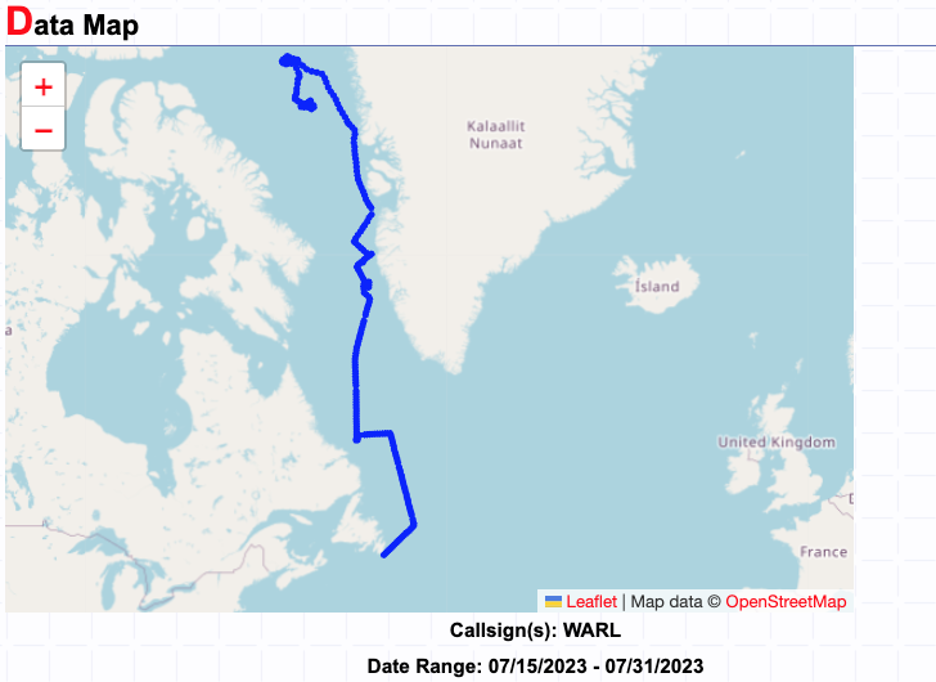

In [2]:
Image("RV_Neil_Armstrong.png")

In [3]:
NEXUS_URL = "https://doms.jpl.nasa.gov/nexus/"

In [4]:
region_of_interest       = {'min_lon':-61, 'max_lon': -50, 'min_lat': 47, 'max_lat': 72}
start                     = datetime(2023, 7, 15)
end                       = datetime(2023, 8, 1)

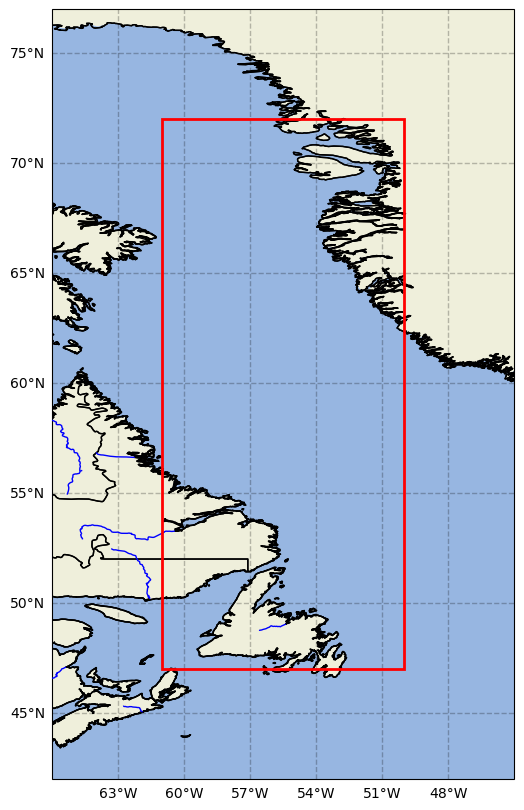

In [5]:
plotting.map_box(region_of_interest, padding=5)

In [6]:
# Connect to GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

layers = ['BlueMarble_NextGeneration',
          'GHRSST_L4_MUR25_Sea_Surface_Temperature_Anomalies',
          'Reference_Features',
          'Reference_Labels']
font = ImageFont.truetype('Roboto-Bold.ttf', size=18)
color = 'rgb(255,255,255)'
frames = []
dates = pd.date_range(start, end,freq='d')

print(f'Obtaining {len(dates)} days of imagery...')

raw_colormap = I.open(BytesIO(requests.get('https://gibs.earthdata.nasa.gov/legends/GHRSST_Sea_Surface_Temperature_Anomalies_H.png').content))
colormap = I.new("RGBA", raw_colormap.size, (255, 255, 255) + (255,))
colormap.paste(raw_colormap, mask=raw_colormap.convert('RGBA').split()[-1])
colormap = colormap.crop((0,0, colormap.width, colormap.height))
for date in dates:
    datatime = date.strftime("%Y-%m-%d")
    
    # Get IMERG_Precipitation_Rate
    img = wms.getmap(layers=layers,  # Layers
                    srs='epsg:4326',  # Map projection
                    bbox=(-61, 47, -50, 72),  # Bounds
                    size=(310, 700),  # Image size
                    time=datatime,  # Time of data
                    format='image/png',  # Image format
                    transparent=True)  # Nodata transparency
    image = I.open(img)
    img_w, img_h = image.size
    background = I.new('RGBA', (img_w, img_h + colormap.size[1]), (255, 255, 255, 255))
    bg_w, bg_h = background.size
    offset = (0, 0)
    background.paste(image, offset)
    background.paste(colormap, ((bg_w - colormap.width) // 2, img_h))
    draw = ImageDraw.Draw(background)
    (x, y) = (225, 12)
    draw.text((x, y), f'SST Anomaly - {datatime}', fill='rgb(255,255,255)', font=font)
    frames.append(background)

Obtaining 18 days of imagery...


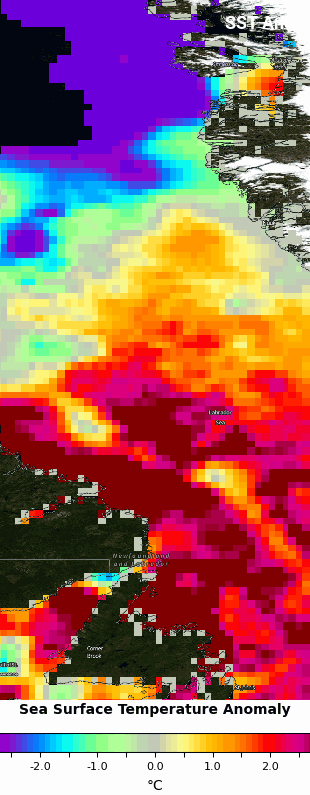

In [ ]:
frames[0].save('MUR25_SST_Anomaly_Summer_2023.gif',
               format='GIF',
               append_images=frames,
               save_all=True,
               duration=500,
               loop=0)
Image('MUR25_SST_Anomaly_Summer_2023.gif')

### Daily Difference Average
Subtracts daily values from climatology, then averages the difference per day.

In [8]:
daily_diff_data = data_processing.daily_diff("https://a106a87ec5ba747c5915cc0ec23c149f-881305611.us-west-2.elb.amazonaws.com/nexus/", 'MUR25-JPL-L4-GLOB-v04.2', 'MUR25-JPL-L4-GLOB-v04.2_clim', region_of_interest, start, end)

url
 https://a106a87ec5ba747c5915cc0ec23c149f-881305611.us-west-2.elb.amazonaws.com/nexus//dailydifferenceaverage_spark?dataset=MUR25-JPL-L4-GLOB-v04.2&climatology=MUR25-JPL-L4-GLOB-v04.2_clim&b=-61,47,-50,72&startTime=2023-07-15T00:00:00Z&endTime=2023-08-01T00:00:00Z

Waiting for response from server... took 4.69996045900001 seconds


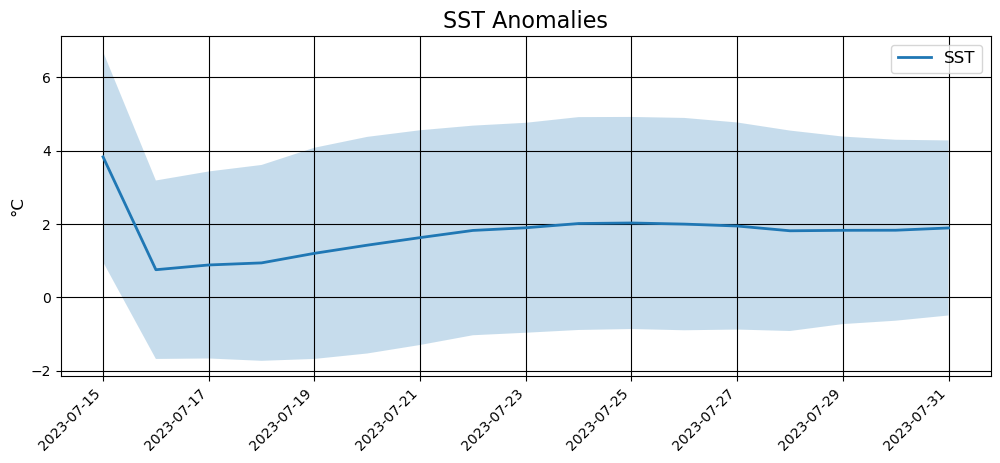

In [9]:
plotting.timeseries_bands_plot(daily_diff_data, 'SST', '', '°C', 'SST Anomalies')

### Data Match Up of MUR SST to SAMOS
Validate satellite SST with in situ SST

In [10]:
matchup_url = f'{NEXUS_URL}/match_spark'

query_params = {
    'primary': 'MUR25-JPL-L4-GLOB-v04.2',
    'secondary': 'SAMOS',
    'startTime': '2023-07-15T00:00:00Z',
    'endTime': '2023-07-31T23:59:59Z',
    'tt': 43200,  # Time tolerance in seconds
    'rt': 18000,  # Spatial tolerance in meters
    'b': '-61,47,-50,72',
    'platforms': '30,31',
    'parameter': 'sea_water_temperature',
    'depthMin': -1,
    'depthMax': 5,
    'matchOnce': 'true',
    'prioritizeDistance': True
}

primary_points, secondary_points, execution_id = cdms_processing.execute_matchup_request(matchup_url, query_params, query_params["parameter"])

https://doms.jpl.nasa.gov/nexus//match_spark?primary=MUR25-JPL-L4-GLOB-v04.2&secondary=SAMOS&startTime=2023-07-15T00%3A00%3A00Z&endTime=2023-07-31T23%3A59%3A59Z&tt=43200&rt=18000&b=-61%2C47%2C-50%2C72&platforms=30%2C31&parameter=sea_water_temperature&depthMin=-1&depthMax=5&matchOnce=true&prioritizeDistance=True
Execution ID: 91517675-93f7-40d9-ae05-4209c5d8dca4
Total number of primary matched points 322
Total number of secondary matched points 322


In [11]:
df = cdms_processing.fetch_result(execution_id, "NETCDF", "mur_sst_summer_2023_anomaly.nc", ["sea_surface_foundation_temperature"], ["sea_water_temperature"])
pd.set_option("display.max_rows", 100)
from IPython.core.display import display
display(df)

,PrimaryData_lon,PrimaryData_lat,PrimaryData_sea_surface_foundation_temperature,PrimaryData_datetime,SecondaryData_lon,SecondaryData_lat,SecondaryData_sea_water_temperature,SecondaryData_datetime
0,-55.125,66.375,3.532013,2023-07-23 08:59:44,-54.851,66.376,3.38,2023-07-22 21:00:48
1,-56.375,58.375,11.402985,2023-07-20 08:59:44,-56.216,58.388,12.23,2023-07-19 21:00:48
2,-55.875,56.125,10.613007,2023-07-19 08:59:44,-56.146,56.119,11.74,2023-07-19 08:32:00
3,-55.875,65.375,2.622009,2023-07-22 08:59:44,-55.554,65.447,0.60,2023-07-22 06:13:20
4,-53.875,55.875,10.786011,2023-07-17 08:59:44,-53.879,55.887,11.49,2023-07-17 18:52:48
...,...,...,...,...,...,...,...,...
317,-55.125,55.875,11.057007,2023-07-18 08:59:44,-55.125,55.837,11.30,2023-07-17 22:49:36
318,-55.375,63.125,7.085998,2023-07-21 08:59:44,-55.197,63.101,7.57,2023-07-20 23:40:48
319,-55.375,65.125,3.947998,2023-07-21 08:59:44,-55.279,65.005,4.49,2023-07-21 11:54:40
320,-55.625,61.875,8.178009,2023-07-20 08:59:44,-55.884,61.913,7.96,2023-07-20 16:34:08


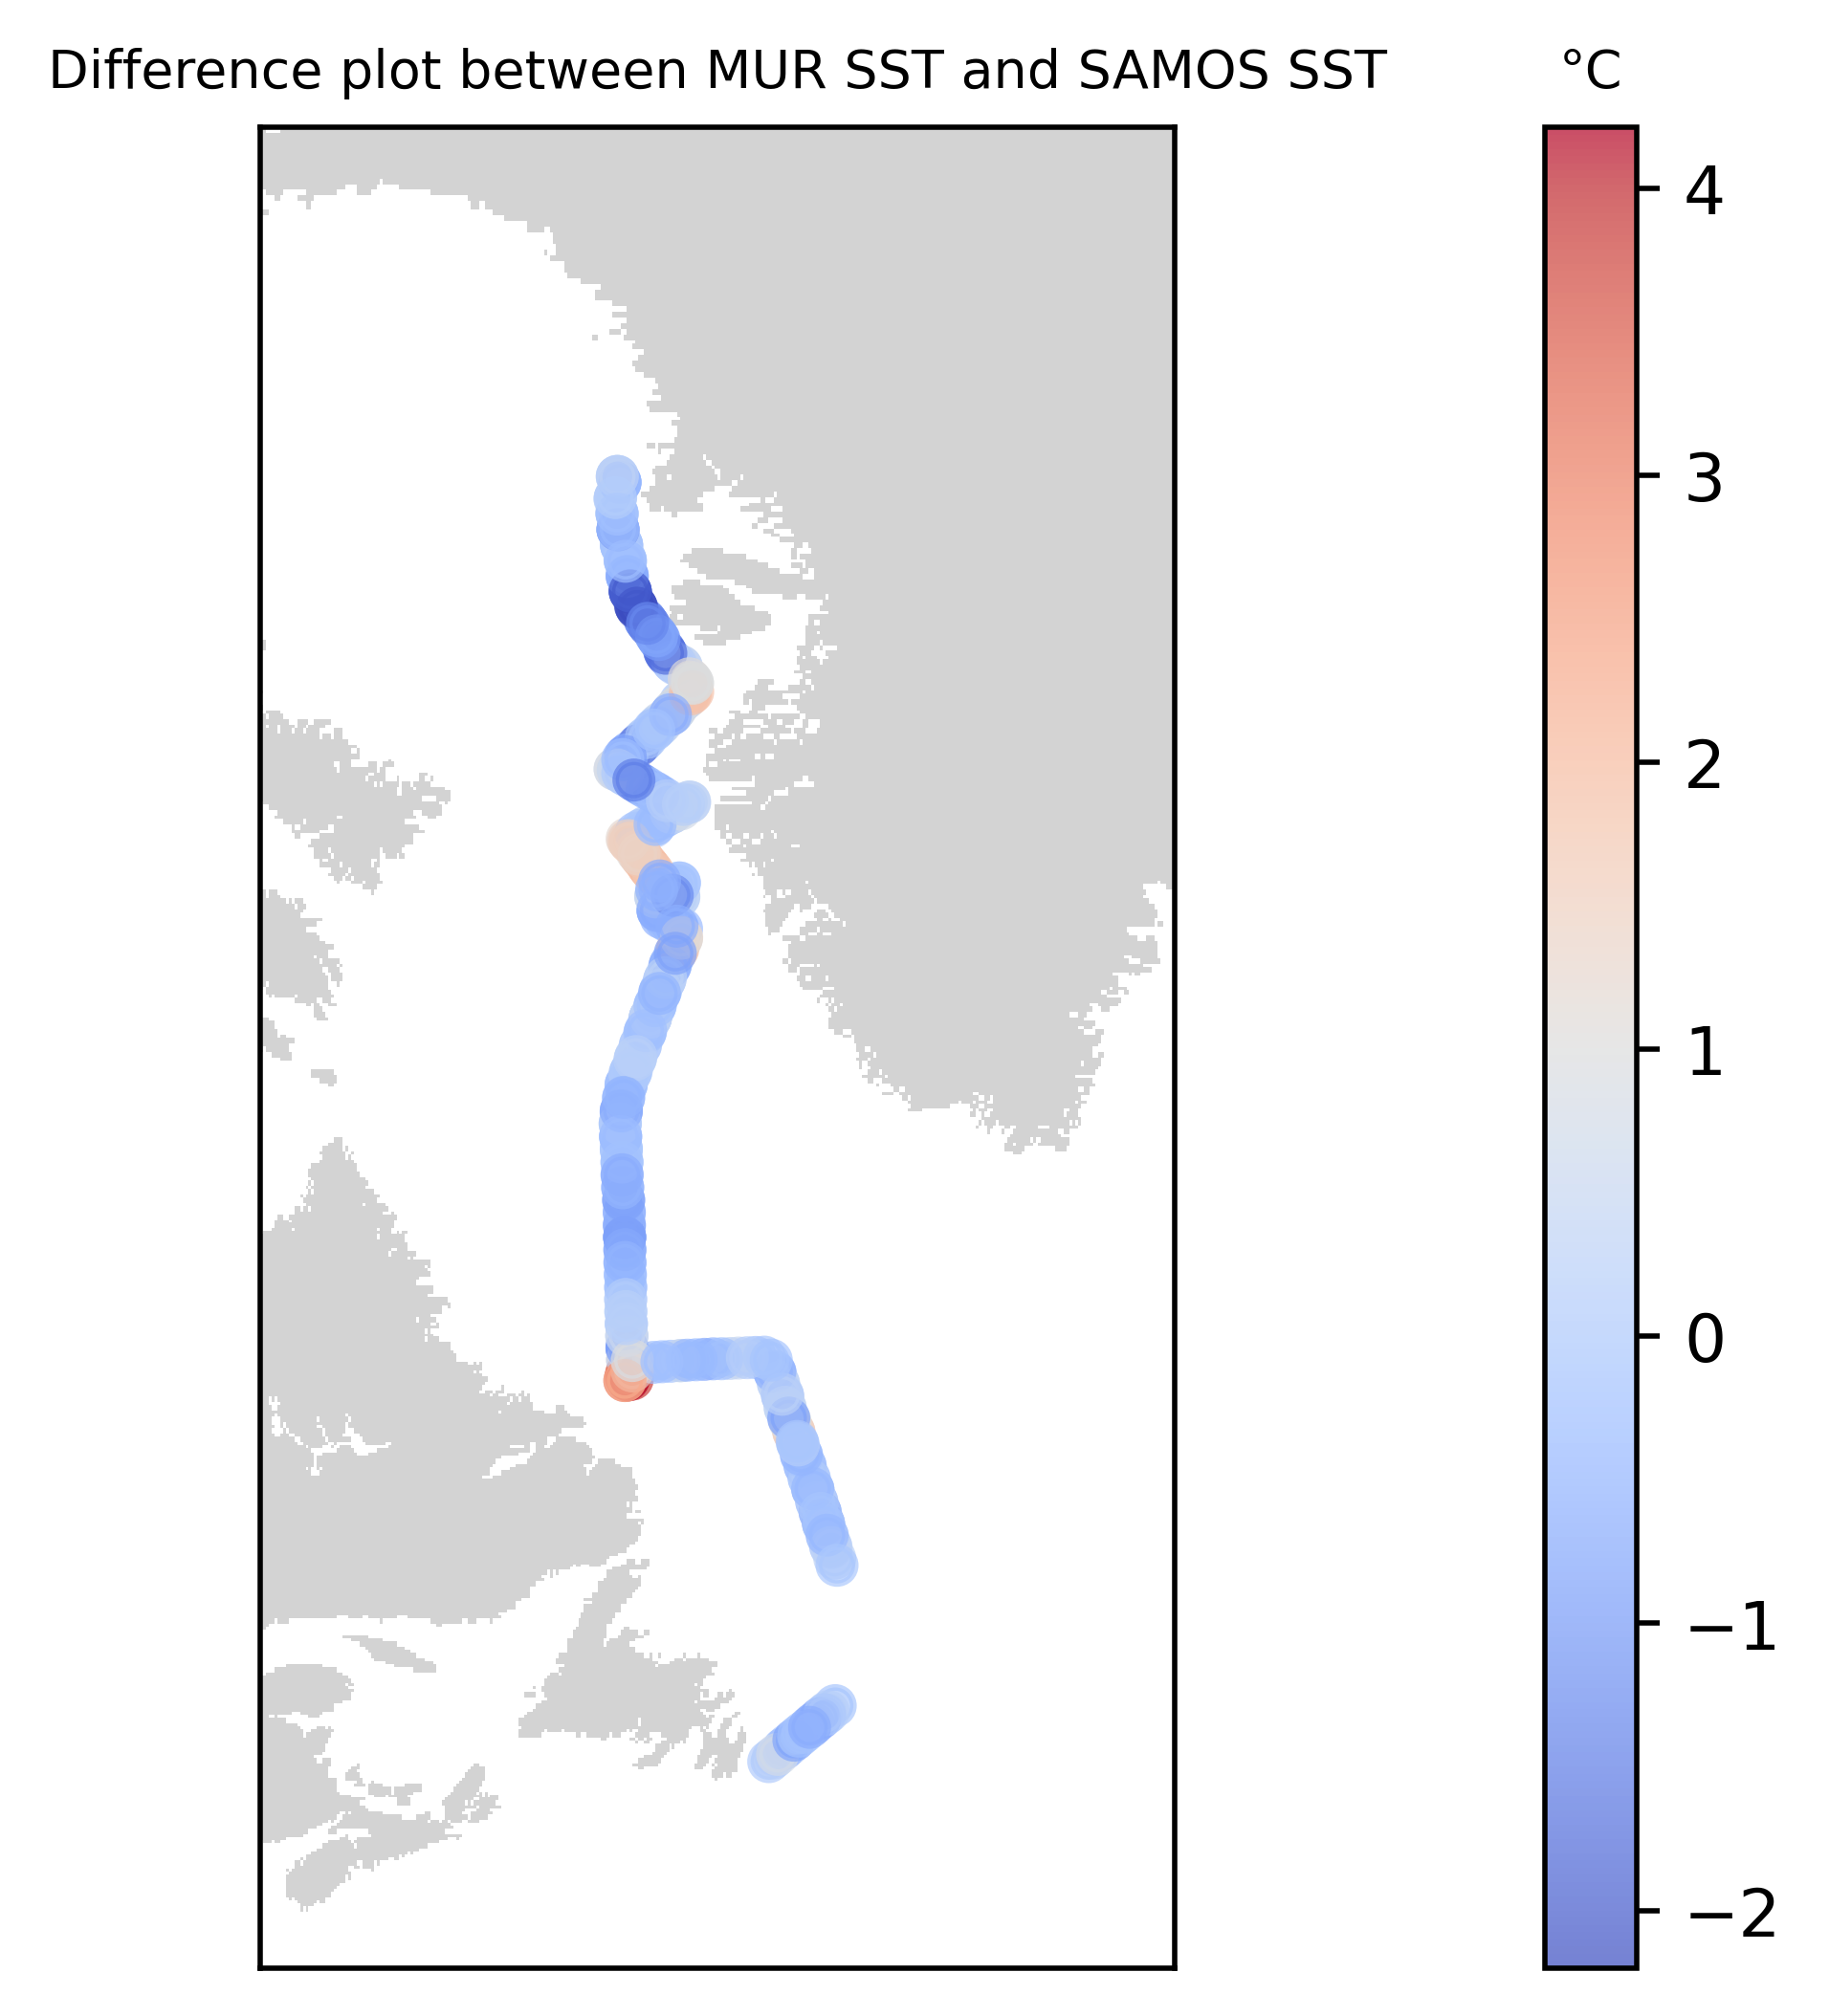

In [12]:
cdms_processing.generate_diff_plot(primary_points, secondary_points, "sea_surface_foundation_temperature", "sea_water_temperature", '°C', "Difference plot between MUR SST and SAMOS SST")

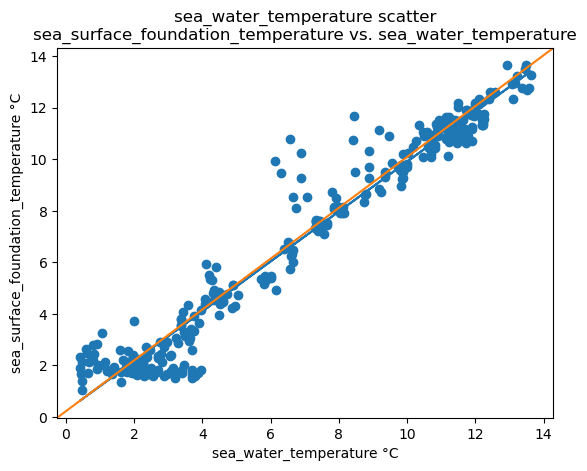

In [13]:
cdms_processing.generate_scatter_plot(primary_points, secondary_points, "sea_surface_foundation_temperature", "sea_water_temperature", query_params['parameter'], '°C')